In [1]:
from experiments.partial import build_partial, plot_partial, pretrain_partial
from pathlib import Path
import numpy as np

from lafomo.datasets import DrosophilaSpatialTranscriptomics, HomogeneousReactionDiffusion
from lafomo.trainers import PartialPreEstimator
from lafomo.plot import plot_spatiotemporal_data
from lafomo.plot.misc import plot_variational_dist
from lafomo.utilities.torch import spline_interpolate_gradient, softplus
from lafomo.utilities.data import dros_ground_truth
from matplotlib import pyplot as plt
import torch
from lafomo.configuration import VariationalConfiguration

In [2]:
drosophila = True
if drosophila:
    gene = 'gt'
    dataset = DrosophilaSpatialTranscriptomics(
        gene=gene, data_dir='../../../data', scale=True, disc=1)
    params = dict(lengthscale=[20, 10],
                  **dros_ground_truth(gene),
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=True,
                  zero_mean=True,
                  clamp=True)
    disc = dataset.disc
else:
    data = 'toy-spatial'
    dataset = HomogeneousReactionDiffusion(data_dir='../../../data')
    params = dict(lengthscale=0.2,
                  sensitivity=1,
                  decay=0.1,
                  diffusion=0.01,
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=False,
                  clamp=False)
    disc = 1
model_name = '0savedmodel'
# model_name = 'epoch165'
# model_name = 'model_with_3'
lfm, trainer, plotter = build_partial(
    dataset,
    params)#,
    # reload=f'../../../experiments/{data}/partial/{model_name}')
lfm.gp_model.covar_module.lengthscale

tx torch.Size([2, 512])
x dp is set to tensor(1., dtype=torch.float64)


tensor([[[20.0000, 10.0000]]], dtype=torch.float64, grad_fn=<SoftplusBackward>)

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


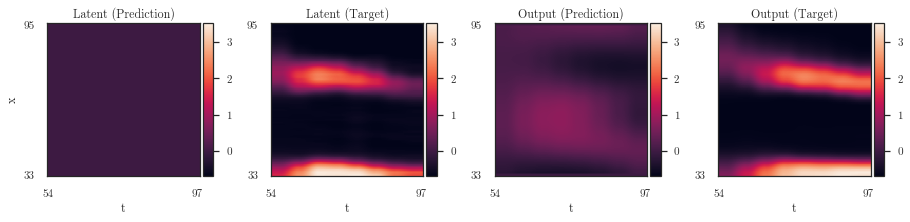

In [3]:
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

In [4]:
pretrain_partial(dataset, lfm, trainer, params);

/Users/jacob/Documents/proj/torchcubicspline/torchcubicspline/interpolate.py:277: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  ../aten/src/ATen/native/BucketizationUtils.h:25.)
  index = torch.bucketize(t.detach(), self._t) - 1


num training 153
Epoch 001/080 - Loss: 0.33 (0.33 0.00) kernel: [[[19.97002649  9.97001707]]]
Epoch 011/080 - Loss: 0.29 (0.29 0.00) kernel: [[[19.83236085  9.88488189]]]
Epoch 021/080 - Loss: 0.26 (0.26 0.00) kernel: [[[19.84878729  9.88612257]]]
Epoch 031/080 - Loss: 0.22 (0.22 0.00) kernel: [[[19.84549775  9.88469033]]]
Epoch 041/080 - Loss: 0.18 (0.18 0.00) kernel: [[[19.81529531  9.8859996 ]]]
Epoch 051/080 - Loss: 0.15 (0.15 0.00) kernel: [[[19.80628765  9.84551196]]]
Epoch 061/080 - Loss: 0.11 (0.11 0.00) kernel: [[[19.95258065  9.70803974]]]
Epoch 071/080 - Loss: 0.07 (0.07 0.00) kernel: [[[20.17451815  9.52854874]]]


torch.Size([426, 2])
torch.Size([512])


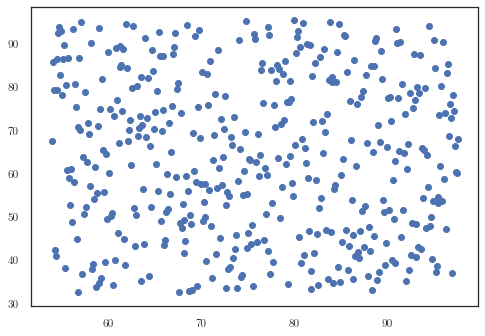

In [5]:
orig_data = dataset.orig_data.squeeze().t()
num_t_orig = orig_data[:, 0].unique().shape[0]
num_x_orig = orig_data[:, 1].unique().shape[0]

tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
y_target = trainer.y_target[0]
ind = lfm.inducing_points[0]
print(ind.shape)
plt.scatter(ind[:, 0], ind[:, 1])
print(trainer.train_mask.shape)

Mean output variance: 0.03320894951911319
Test loss: 1.4794096017496434
prot Q2: 0.472
prot CA: 0.125
mrna Q2: 0.364
mrna CA: 0.260
Epoch 031/040 - Loss: 1.36 (0.45 0.45) kernel: [[[20.42225991  9.73779057]]] s: 0.10020655891674712 dec: 0.10020655891674712 diff: 0.015900012764781094
Mean output variance: 0.03952920682363361
Test loss: 1.4994630875902755
prot Q2: 0.471
prot CA: 0.088
mrna Q2: 0.367
mrna CA: 0.260
Epoch 032/040 - Loss: 1.36 (0.45 0.46) kernel: [[[20.40797207  9.73344118]]] s: 0.10020655891674712 dec: 0.10020655891674712 diff: 0.015900012764781094
Mean output variance: 0.028518628460504944
Test loss: 1.4642968688948381
prot Q2: 0.472
prot CA: 0.096
mrna Q2: 0.363
mrna CA: 0.252
Epoch 033/040 - Loss: 1.34 (0.44 0.45) kernel: [[[20.39254882  9.72880339]]] s: 0.10020655891674712 dec: 0.10020655891674712 diff: 0.015900012764781094
Mean output variance: 0.03655852999519911
Test loss: 1.5135292376463787
prot Q2: 0.442
prot CA: 0.092
mrna Q2: 0.366
mrna CA: 0.240
Epoch 034/040 -

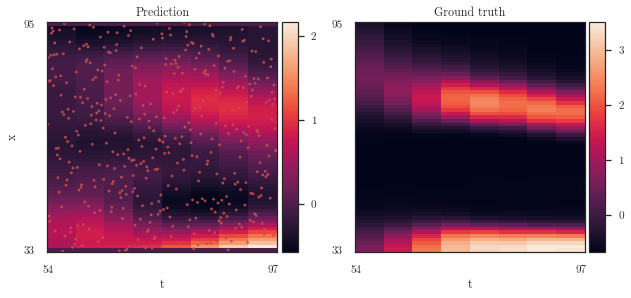

In [7]:
lfm.config.num_samples = 15
trainer.plot_outputs = True
lfm.pretrain(False)
trainer.train(10, report_interval=1);

In [15]:
# for key in trainer.parameter_trace.keys():
#     params = torch.stack(trainer.parameter_trace[key])
#     for i in range(1, params.ndim):
#         params = params.mean(-1)
    # plt.figure()
    # plt.plot(params)
[softplus(param) for param in lfm.fenics_parameters]

[tensor([[0.0970]], dtype=torch.float64),
 tensor([[0.0764]], dtype=torch.float64),
 tensor([[0.0015]], dtype=torch.float64)]

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


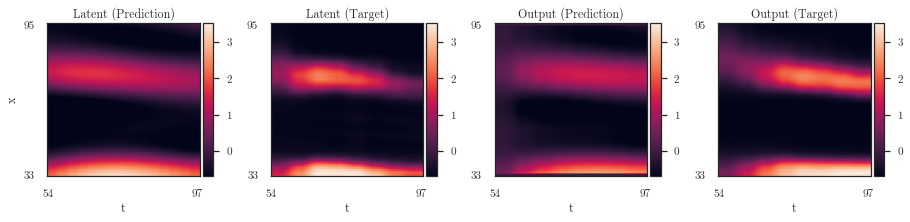

In [15]:
from lafomo.plot import tight_kwargs
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

# plt.savefig(Path('./') / f'kinetics-{gene}.pdf', **tight_kwargs)

In [ ]:
from lafomo.utilities.torch import q2, cia
f = lfm(tx)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]
def cia(y_test, f_mean, f_var):
    return ((y_test >= (f_mean - 1 * f_var.sqrt())) &
            (y_test <= (f_mean + 1 * f_var.sqrt()))).double().mean()

print(f_mean.shape, y_target.shape, f_var.shape)
print('Q2', q2(y_target.squeeze(), f_mean.squeeze()))
print('CA', cia(y_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))

In [ ]:
gp = lfm.gp_model(tx.t())
lf_target = orig_data[trainer.t_sorted, 2]
f_mean = gp.mean.detach().view(num_t, num_x)[::disc].reshape(-1)
f_var = gp.variance.detach().view(num_t, num_x)[::disc].reshape(-1)

print('Q2', q2(lf_target.squeeze(), f_mean.squeeze()))
print('CA', cia(lf_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))


In [16]:
lfm.save('./kr-2005')

In [ ]:
lfm2, trainer2, plotter2 = build_partial(
    dataset,
    params,
    reload='./kr-1205')

In [ ]:
gp = lfm2.gp_model(tx.t())
lf_target = orig_data[trainer.t_sorted, 2]
f_mean = gp.mean.detach()
f_var = gp.variance.detach()

print('Q2', q2(lf_target.squeeze(), f_mean.squeeze()))
print('CA', cia(lf_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))

In [71]:
to_plot = list()
clims = list()
means = {'kr': False, 'kni': True, 'gt': False}
for gene in ['kr', 'kni', 'gt']:
    dataset = DrosophilaSpatialTranscriptomics(
        gene=gene, data_dir='../../../data', scale=True)
    params = dict(lengthscale=10,
                  **dros_params[gene],
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=False,
                  zero_mean=means[gene],
                  clamp=True)
    disc = dataset.disc
    lfm, trainer, plotter = build_partial(
        dataset,
        params,
        reload=f'../../../experiments/{gene}0')

    lfm.eval()
    tx = trainer.tx
    num_t = tx[0, :].unique().shape[0]
    num_x = tx[1, :].unique().shape[0]
    orig_data = dataset.orig_data.squeeze().t()
    num_t_orig = orig_data[:, 0].unique().shape[0]
    num_x_orig = orig_data[:, 1].unique().shape[0]
    disc = dataset.disc if hasattr(dataset, 'disc') else 1

    f = lfm(tx, step=disc)
    f_mean = f.mean.detach()
    f_var = f.variance.detach()
    y_target = trainer.y_target[0]
    ts = tx[0, :].unique().sort()[0].numpy()
    xs = tx[1, :].unique().sort()[0].numpy()
    extent = [ts[0], ts[-1], xs[0], xs[-1]]

    l_target = orig_data[trainer.t_sorted, 2]
    l = lfm.gp_model(tx.t())
    l_mean = l.mean.detach()
    to_plot.append([
            l_mean.view(num_t, num_x).t(),
            l_target.view(num_t_orig, num_x_orig).t(),
            f_mean.view(num_t_orig, num_x_orig).t(),
            y_target.view(num_t_orig, num_x_orig).detach().t(),
    ])

    clims.append(([(l_target.min(), l_target.max())] * 2 + [(y_target.min(), y_target.max())] * 2))

tx torch.Size([2, 512])
x dp is set to tensor(1., dtype=torch.float64)
tx torch.Size([2, 456])
x dp is set to tensor(1., dtype=torch.float64)
tx torch.Size([2, 512])
x dp is set to tensor(1., dtype=torch.float64)


'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


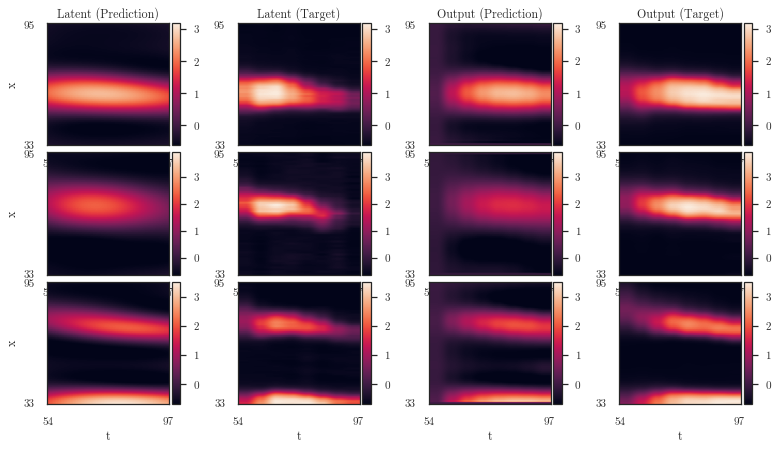

In [72]:
clim = [*clims[0], *clims[1], *clims[2]]
plots = [*to_plot[0], *to_plot[1], *to_plot[2]]

grid = plot_spatiotemporal_data(
    plots,
    extent,
    nrows=3,
    ncols=4,
    titles=[
        'Latent (Prediction)', 'Latent (Target)',
        'Output (Prediction)', 'Output (Target)',] + ['']*8,
    cticks=None,  # [0, 100, 200]
    clim=clim
)
plt.gca().get_figure().set_size_inches(15, 7)
for i in range(8):
    grid[i].set_xticks([])
    grid[i].set_xlabel(None)

for i in range(8, 12):
    grid[i].set_xticks([np.ceil(extent[0]), np.floor(extent[1])])
plt.savefig('dros_combined.pdf', **tight_kwargs)